In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings('ignore')

## Read datasets and labels

In [2]:
df = pd.read_csv("../1_Attack dataset/Local Area Network/data/attacker_dataset.csv") # attack dataset
attack_classes = pd.read_csv("../1_Attack dataset/Local Area Network/data/attack_labels_sbseg.csv") # labels
bonafide = pd.read_csv('../2_Bonafide dataset/data/bonafide_dataset_20191121.csv.gz') # bonafide dataset
print(df.shape, bonafide.shape)

(436152, 41) (103094, 41)


### Attack labels

In [3]:
attack_classes['label'].unique()

array(['nmap_tcp_syn', 'nmap_tcp_conn', 'nmap_tcp_null', 'nmap_tcp_xmas',
       'nmap_tcp_fin', 'nmap_tcp_ack', 'nmap_tcp_window',
       'nmap_tcp_maimon', 'unicornscan_tcp_syn', 'unicornscan_tcp_conn',
       'unicornscan_tcp_null', 'unicornscan_tcp_xmas',
       'unicornscan_tcp_fxmas', 'unicornscan_tcp_fin',
       'unicornscan_tcp_ack', 'hping_tcp_syn', 'hping_tcp_null',
       'hping_tcp_xmas', 'hping_tcp_fin', 'hping_tcp_ack', 'zmap_tcp_syn',
       'masscan_tcp_syn', 'hping_tcp_syn_dos', 'hping_tcp_ack_dos',
       'hping_tcp_rst_dos'], dtype=object)

### Create **attack dataset** with labels defined by  *ip_src*

In [4]:
df_labeled = df.merge(attack_classes, how='inner', left_on='ip.src', right_on='ip')
df_labeled.drop(['ip'], axis=1, inplace=True)
df_labeled.head(2)

frame_info.encap_type                      frame_info.time  \
0                      1  Jan  1, 1970 08:01:50.630938000 CST   
1                      1  Jan  1, 1970 08:01:50.630942000 CST   

   frame_info.time_epoch  frame_info.number  frame_info.len  \
0             110.630938                 22              58   
1             110.630942                 23              58   

   frame_info.cap_len eth.type  ip.version  ip.hdr_len  ip.tos   ip.id  \
0                  58   0x0800           4          20     NaN  0xc4b3   
1                  58   0x0800           4          20     NaN  0x6af6   

  ip.flags  ip.flags.rb  ip.flags.df  ip.flags.mf  ip.frag_offset  ip.ttl  \
0     0x00        False        False        False               0      53   
1     0x00        False        False        False               0      57   

   ip.proto ip.checksum      ip.src       ip.dst  ip.len ip.dsfield  \
0         6      0x00f2  172.16.0.3  10.10.10.10      44       0x00   
1         6      0x56af  172.16.0.3  10.10.10.10      44       0x00   

   tcp.srcport  tcp.dstport  tcp.seq  tcp.ack  tcp.len  tcp.hdr_len tcp.flags  \
0      62919.0       8888.0      0.0      0.0      0.0         24.0    0x0002   
1      62919.0        445.0      0.0      0.0      0.0         24.0    0x0002   

  tcp.flags.fin tcp.flags.syn tcp.flags.reset tcp.flags.push tcp.flags.ack  \
0         False          True           False          False         False   
1         False          True           False          False         False   

  tcp.flags.urg tcp.flags.cwr  tcp.window_size tcp.checksum  \
0         False         False           1024.0       0x4ffd   
1         False         False           1024.0       0x70f8   

   tcp.urgent_pointer  tcp.options.mss_val         label  
0                 0.0               1460.0  nmap_tcp_syn  
1                 0.0               1460.0  nmap_tcp_syn

In [5]:
bonafide['label'] = "bonafide" # create column label on bonafide dataset

## Comparing _bonafide_ and _attack_ datasets
> Check if both dataset have the same columns/features/attributes and calculate the balance (%) of bonafide and attack packets

In [6]:
if (df_labeled.columns == bonafide.columns).all():
    examples_attack = df_labeled.shape[0]
    examples_bonafide = bonafide.shape[0]
    total = examples_attack+examples_bonafide
    print('Total examples of {0} with {1:0.2f} of attack and {2:0.2f} bonafide packets'.format(total, examples_attack/total, examples_bonafide/total))

Total examples of 199618 with 0.48 of attack and 0.52 bonafide packets


## Pre-processing
> Required to convert features that were extracted from `pcap` as hexadecimal
> Filled the values with NaN with Zero

In [7]:
fields = ['eth.type', 'ip.id', 'ip.flags', 'ip.checksum', 'ip.dsfield', 'tcp.flags', 'tcp.checksum']

for field in fields:
    df_labeled[field] = df_labeled[field].apply(lambda x: int(str(x), 16))
    

In [8]:
bonafide = bonafide.fillna(0)
for field in fields:
    bonafide[field] = bonafide[field].apply(lambda x: int(str(x), 16))

### Create AB-TRAP dataset with all packets (bonafide and attack)

In [9]:
full_data = pd.concat([bonafide, df_labeled])

### Check if there are packets with the protocol field different than TCP (value 6)

In [10]:
wrong_proto = full_data[full_data['ip.proto'] != 6]['label'].value_counts().values
full_data = full_data[full_data['ip.proto'] == 6]
print("It was found and removed", wrong_proto,"packets.")

It was found and removed [11708] packets.


### Features not applicable to this study

> Remove features from link layer - layer 2:
> - frame_info.time
> - frame_info.encap_type
> - frame_info.time_epoch
> - frame_info.number
> - frame_info.len
> - frame_info.cap_len
> - eth.type

> Remove features that are redundant or invariable
> - ip.version - we consider only IPv4
> - ip.proto - this study is applicable only to TCP
> - ip.src - this attribute is removed to allow the generalization of learning (not learn past attackers)
> - ip.dst - this attribute is removed to allow the generalization of learning (not learn past targets)
> - ip.flags - this is removed because we use bit-set of flags
> - tcp.flags - this is removed because we use bit-set of flags

In [11]:
full_data.drop(columns=['frame_info.time', 'frame_info.encap_type', 'frame_info.time_epoch', 'frame_info.number', 
                        'frame_info.len', 'frame_info.cap_len', 'eth.type', 'ip.flags', 'ip.src', 'ip.dst',
                        'ip.version', 'ip.proto', 'tcp.flags'], axis=1, inplace=True)

## Exploratory Data Analysis

In [12]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187910 entries, 1 to 96523
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ip.hdr_len           187910 non-null  float64
 1   ip.tos               91386 non-null   float64
 2   ip.id                187910 non-null  int64  
 3   ip.flags.rb          187910 non-null  float64
 4   ip.flags.df          187910 non-null  float64
 5   ip.flags.mf          187910 non-null  float64
 6   ip.frag_offset       187910 non-null  float64
 7   ip.ttl               187910 non-null  float64
 8   ip.checksum          187910 non-null  int64  
 9   ip.len               187910 non-null  float64
 10  ip.dsfield           187910 non-null  int64  
 11  tcp.srcport          187910 non-null  float64
 12  tcp.dstport          187910 non-null  float64
 13  tcp.seq              187910 non-null  float64
 14  tcp.ack              187910 non-null  float64
 15  tcp.len              18

In [13]:
full_data.describe()

ip.hdr_len   ip.tos          ip.id  ip.flags.rb    ip.flags.df  \
count    187910.0  91386.0  187910.000000     187910.0  187910.000000   
mean         20.0      0.0   31474.317381          0.0       0.350498   
std           0.0      0.0   19531.951168          0.0       0.477127   
min          20.0      0.0       0.000000          0.0       0.000000   
25%          20.0      0.0   14366.250000          0.0       0.000000   
50%          20.0      0.0   31233.000000          0.0       0.000000   
75%          20.0      0.0   48483.000000          0.0       1.000000   
max          20.0      0.0   65535.000000          0.0       1.000000   

       ip.flags.mf  ip.frag_offset         ip.ttl    ip.checksum  \
count     187910.0        187910.0  187910.000000  187910.000000   
mean           0.0             0.0     101.701703   32500.219807   
std            0.0             0.0      76.332102   18887.011379   
min            0.0             0.0       1.000000       0.000000   
25%            0.0             0.0      60.000000   15981.000000   
50%            0.0             0.0      62.000000   31982.000000   
75%            0.0             0.0     115.000000   48794.000000   
max            0.0             0.0     254.000000   65534.000000   

              ip.len     ip.dsfield    tcp.srcport    tcp.dstport  \
count  187910.000000  187910.000000  187910.000000  187910.000000   
mean      441.769060       1.361929   30382.087797   17372.995226   
std       586.013783       6.452331   23717.286401   23815.910784   
min        40.000000       0.000000       0.000000       0.000000   
25%        40.000000       0.000000    1291.250000      22.000000   
50%       160.000000       0.000000   34724.500000     443.000000   
75%       612.750000       0.000000   53030.000000   49235.000000   
max      5981.000000     224.000000   65535.000000   65534.000000   

            tcp.seq       tcp.ack        tcp.len    tcp.hdr_len  \
count  1.879100e+05  1.879100e+05  187910.000000  187910.000000   
mean   1.465039e+08  3.886024e+08     398.052025      23.717035   
std    6.172827e+08  6.417386e+08     582.605656       5.962184   
min    0.000000e+00  0.000000e+00       0.000000      20.000000   
25%    1.000000e+00  1.000000e+00       0.000000      20.000000   
50%    1.000000e+00  2.156000e+03     120.000000      20.000000   
75%    2.508361e+06  6.569725e+08     565.000000      32.000000   
max    4.294967e+09  4.294967e+09    5941.000000      60.000000   

       tcp.window_size   tcp.checksum  tcp.urgent_pointer  tcp.options.mss_val  
count     1.879100e+05  187910.000000       187910.000000         95393.000000  
mean      4.946986e+03   32215.056378            0.463988           133.428553  
std       6.196055e+04   19156.975547          142.074306           438.001073  
min       0.000000e+00       0.000000            0.000000             0.000000  
25%       2.790000e+02   15477.000000            0.000000             0.000000  
50%       5.120000e+02   31909.000000            0.000000             0.000000  
75%       1.024000e+03   48781.000000            0.000000             0.000000  
max       1.644544e+07   65534.000000        46335.000000          8961.000000

In [14]:
# check features with zero variance (not useful for learning)
# (full_data.var() == 0)
zero_variance = full_data.drop('label', axis=1).var() == 0
print(zero_variance)

ip.hdr_len              True
ip.tos                  True
ip.id                  False
ip.flags.rb             True
ip.flags.df            False
ip.flags.mf             True
ip.frag_offset          True
ip.ttl                 False
ip.checksum            False
ip.len                 False
ip.dsfield             False
tcp.srcport            False
tcp.dstport            False
tcp.seq                False
tcp.ack                False
tcp.len                False
tcp.hdr_len            False
tcp.flags.fin          False
tcp.flags.syn          False
tcp.flags.reset        False
tcp.flags.push         False
tcp.flags.ack          False
tcp.flags.urg          False
tcp.flags.cwr          False
tcp.window_size        False
tcp.checksum           False
tcp.urgent_pointer     False
tcp.options.mss_val    False
dtype: bool


In [15]:
# remove columns with zero variance
full_data.drop(columns=['ip.hdr_len', 'ip.tos', 'ip.flags.rb', 
                        'ip.flags.mf', 'ip.frag_offset'], axis=1, inplace=True)

### Univariate features analysis (boxplot)

In [16]:
full_data.columns

Index(['ip.id', 'ip.flags.df', 'ip.ttl', 'ip.checksum', 'ip.len', 'ip.dsfield',
       'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.checksum', 'tcp.urgent_pointer',
       'tcp.options.mss_val', 'label'],
      dtype='object')

In [17]:
_columns = 3
lines = int(full_data.shape[1]/_columns)+1

plt.figure(figsize=[100, 100])

i = 1
for column in full_data.columns:
    if column != "label":
        plt.subplot(lines, _columns, i)
        # Using matplotlib's boxplot directly instead of pandas
        plt.boxplot(full_data[column])
        plt.title(column)  # Add title to identify each feature
        i += 1

plt.tight_layout()  # Adjust subplot layout
plt.show()

### Bivariate Analysis - Linear correlation (absolute threshold of 0.5)

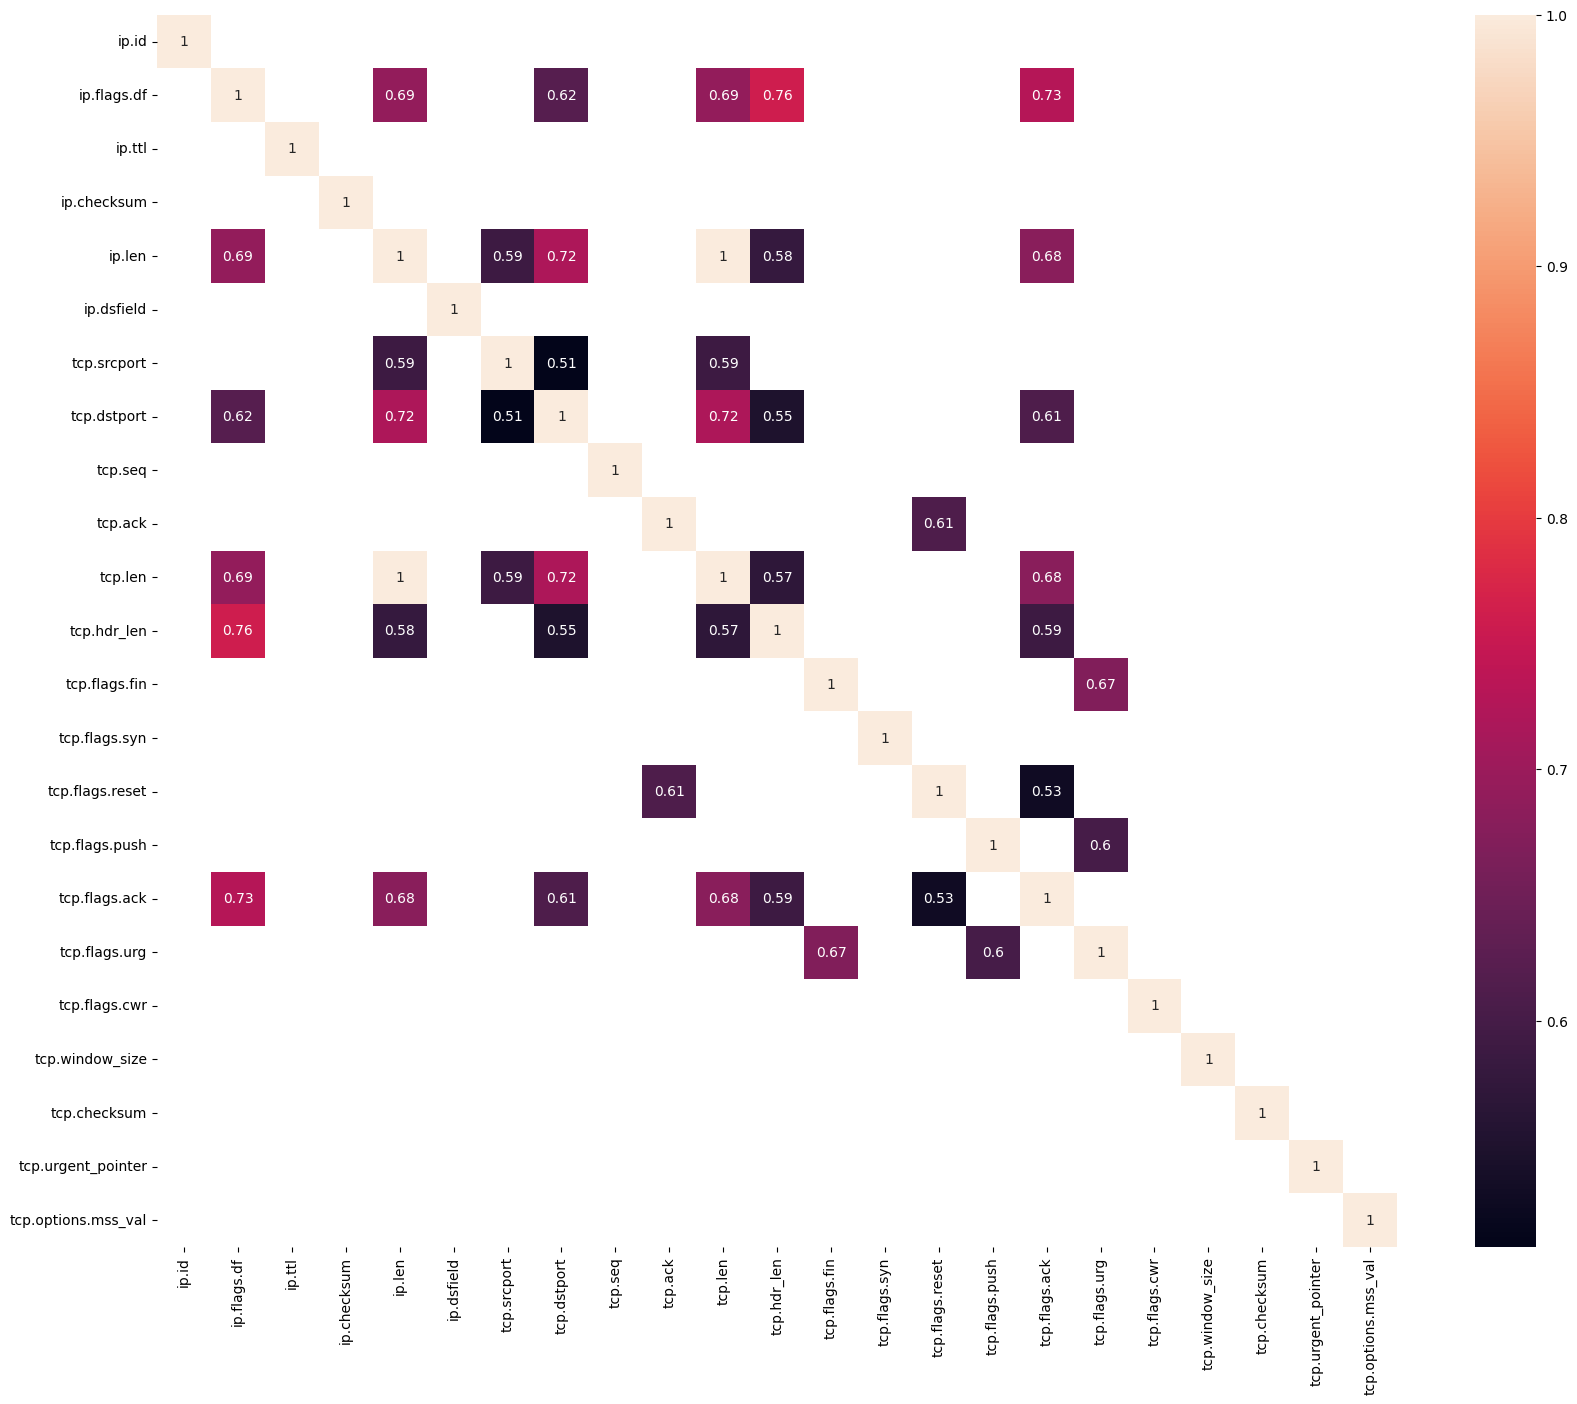

In [18]:
import seaborn as sns
high_corr = full_data.drop('label', axis=1).corr().abs().round(2)
high_corr_var = high_corr[high_corr>0.5]
plt.figure(figsize = (20,16))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

## Machine Learning - Binary Classification _(attack x bonafide)_

In [19]:
full_data['label'].value_counts()

label
bonafide                 91386
hping_tcp_rst_dos        51424
hping_tcp_syn_dos        13507
hping_tcp_ack_dos         8055
masscan_tcp_syn           3510
unicornscan_tcp_conn      1004
unicornscan_tcp_xmas      1003
unicornscan_tcp_syn       1003
unicornscan_tcp_null      1003
unicornscan_tcp_fin       1003
unicornscan_tcp_fxmas     1003
unicornscan_tcp_ack       1002
nmap_tcp_conn             1002
nmap_tcp_xmas             1001
nmap_tcp_null             1001
nmap_tcp_syn              1001
nmap_tcp_fin              1001
hping_tcp_syn             1001
nmap_tcp_maimon           1000
nmap_tcp_ack              1000
nmap_tcp_window           1000
hping_tcp_ack             1000
hping_tcp_fin             1000
hping_tcp_xmas            1000
hping_tcp_null            1000
Name: count, dtype: int64

In [20]:
# Convert 'bonafide' to 0
full_data.loc[full_data.label == "bonafide", "label"] = 0

# Convert DDoS attack labels to 1
ddos_attacks = ["hping_tcp_rst_dos", "hping_tcp_syn_dos", "hping_tcp_ack_dos"]
full_data.loc[full_data.label.isin(ddos_attacks), "label"] = 1

# Convert remaining port scan attack labels to 2
full_data.loc[~full_data.label.isin([0, 1]), "label"] = 2

# Display label distribution
print(full_data['label'].value_counts())

label
0    91386
1    72986
2    23538
Name: count, dtype: int64


In [21]:
full_data.shape

(187910, 24)

In [22]:
# It is removed ttl because previous attempt shows that it is learning the LAN architecture TTL=62
# (from scan tools TTL=64 minus 2 routers in the infrastructure)

# sequence, checksum and acknowledge features because they are random

# removed source and destination ports to be agnostic regarding the service ports

# removed tcp.options.mss_val because it is dificult to be retrieved as LKM

full_data.drop(columns=["ip.checksum", "ip.ttl", "tcp.checksum", "tcp.dstport", "tcp.seq", "tcp.srcport", 
                        "tcp.ack", "tcp.options.mss_val"], axis=1, inplace=True)

In [23]:
full_data

ip.id  ip.flags.df  ip.len  ip.dsfield  tcp.len  tcp.hdr_len  \
1      46834          0.0    40.0           0      0.0         20.0   
3       3793          1.0   537.0           8    485.0         32.0   
4          0          1.0    80.0           0      0.0         60.0   
5       8559          1.0    54.0           0      2.0         32.0   
6      54321          0.0    40.0           8      0.0         20.0   
...      ...          ...     ...         ...      ...          ...   
96519  60774          0.0   160.0           0    120.0         20.0   
96520   3504          0.0   160.0           0    120.0         20.0   
96521  33930          0.0   160.0           0    120.0         20.0   
96522  24302          0.0   160.0           0    120.0         20.0   
96523  12040          0.0   160.0           0    120.0         20.0   

      tcp.flags.fin tcp.flags.syn tcp.flags.reset tcp.flags.push  \
1               0.0           1.0             0.0            0.0   
3               0.0           0.0             0.0            1.0   
4               0.0           0.0             0.0            0.0   
5               0.0           0.0             0.0            1.0   
6               0.0           1.0             0.0            0.0   
...             ...           ...             ...            ...   
96519         False         False            True          False   
96520         False         False            True          False   
96521         False         False            True          False   
96522         False         False            True          False   
96523         False         False            True          False   

      tcp.flags.ack tcp.flags.urg tcp.flags.cwr  tcp.window_size  \
1               0.0           0.0           0.0           1024.0   
3               1.0           0.0           0.0            252.0   
4               1.0           0.0           0.0           4677.0   
5               1.0           0.0           0.0            115.0   
6               0.0           0.0           0.0          65535.0   
...             ...           ...           ...              ...   
96519         False         False         False            512.0   
96520         False         False         False            512.0   
96521         False         False         False            512.0   
96522         False         False         False            512.0   
96523         False         False         False            512.0   

       tcp.urgent_pointer label  
1                     0.0     0  
3                     0.0     0  
4                     0.0     0  
5                     0.0     0  
6                     0.0     0  
...                   ...   ...  
96519                 0.0     1  
96520                 0.0     1  
96521                 0.0     1  
96522                 0.0     1  
96523                 0.0     1  

[187910 rows x 16 columns]

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

algorithms = {
    "MLP" : (MLPClassifier(), {
       "hidden_layer_sizes" : (10, 10),
    }),
    # "XGB" : (XGBClassifier(), {}),
    "NB" : (GaussianNB(), {}),
    "LR" : (LogisticRegression(), {}),
    "RF" : (RandomForestClassifier(random_state=17, n_jobs=-1), {
        "n_estimators" : [10, 50, 100, 200],
        "criterion" : ("gini", "entropy"), 
        "max_depth": [5, 10],
        "class_weight": (None, "balanced", "balanced_subsample")
    }),
    "DT" : (DecisionTreeClassifier(), {
        "criterion": ("gini", "entropy"), 
        "max_depth": [x for x in range(1,21)],
        "class_weight": (None, "balanced")
    }),
}

full_data = full_data.fillna(0)
X = full_data.drop(columns = ["label"])
y = full_data.label

print(X.shape, y.shape)

(187910, 15) (187910,)


In [25]:
X.head()

ip.id  ip.flags.df  ip.len  ip.dsfield  tcp.len  tcp.hdr_len tcp.flags.fin  \
1  46834          0.0    40.0           0      0.0         20.0           0.0   
3   3793          1.0   537.0           8    485.0         32.0           0.0   
4      0          1.0    80.0           0      0.0         60.0           0.0   
5   8559          1.0    54.0           0      2.0         32.0           0.0   
6  54321          0.0    40.0           8      0.0         20.0           0.0   

  tcp.flags.syn tcp.flags.reset tcp.flags.push tcp.flags.ack tcp.flags.urg  \
1           1.0             0.0            0.0           0.0           0.0   
3           0.0             0.0            1.0           1.0           0.0   
4           0.0             0.0            0.0           1.0           0.0   
5           0.0             0.0            1.0           1.0           0.0   
6           1.0             0.0            0.0           0.0           0.0   

  tcp.flags.cwr  tcp.window_size  tcp.urgent_pointer  
1           0.0           1024.0                 0.0  
3           0.0            252.0                 0.0  
4           0.0           4677.0                 0.0  
5           0.0            115.0                 0.0  
6           0.0          65535.0                 0.0

In [26]:
X = X.astype(int) 
X.head()

ip.id  ip.flags.df  ip.len  ip.dsfield  tcp.len  tcp.hdr_len  \
1  46834            0      40           0        0           20   
3   3793            1     537           8      485           32   
4      0            1      80           0        0           60   
5   8559            1      54           0        2           32   
6  54321            0      40           8        0           20   

   tcp.flags.fin  tcp.flags.syn  tcp.flags.reset  tcp.flags.push  \
1              0              1                0               0   
3              0              0                0               1   
4              0              0                0               0   
5              0              0                0               1   
6              0              1                0               0   

   tcp.flags.ack  tcp.flags.urg  tcp.flags.cwr  tcp.window_size  \
1              0              0              0             1024   
3              1              0              0              252   
4              1              0              0             4677   
5              1              0              0              115   
6              0              0              0            65535   

   tcp.urgent_pointer  
1                   0  
3                   0  
4                   0  
5                   0  
6                   0

## Grid Search

In [27]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score

# K-fold setup remains the same
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)  # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)  # Validation

# Modify the performance metric to handle multiclass
# Options for average: 'micro', 'macro', 'weighted'
perf = lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro')  # Using macro average

score = {}
for algorithm in algorithms.keys():
    score[algorithm] = []

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        #prep = MinMaxScaler()
        
        prep.fit(X.iloc[train])
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        score[algorithm].append(perf(y.iloc[test], best.predict(prep.transform(X.iloc[test]))))

MLP
NB
LR
RF
DT


In [28]:
# f1-scores
pd.DataFrame.from_dict(score)

MLP        NB        LR        RF        DT
0  0.963998  0.729672  0.893589  0.977140  0.977227
1  0.967602  0.740651  0.883354  0.978966  0.978966
2  0.965512  0.730999  0.891495  0.978680  0.978686
3  0.966747  0.734467  0.887585  0.978142  0.978013
4  0.965258  0.730681  0.859984  0.979285  0.979197
5  0.976097  0.727530  0.901628  0.978382  0.978341
6  0.967285  0.732148  0.900062  0.977983  0.978254
7  0.966397  0.729253  0.883684  0.978210  0.978210
8  0.966344  0.727418  0.896237  0.978409  0.978409
9  0.967670  0.735010  0.892753  0.978966  0.979325

## ROC/AUC evaluation

In [29]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Define custom scoring function for multi-class ROC AUC
def multi_class_roc_auc(y_true, y_prob):
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    if len(np.unique(y_true)) == 2:  # Handle binary classification case
        y_prob = y_prob[:, 1].reshape(-1, 1)
        y_true_bin = y_true_bin.reshape(-1, 1)
    return roc_auc_score(y_true_bin, y_prob, 
                        multi_class='ovr', 
                        average='macro')

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)  # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)  # Validation

results = {}
for algorithm in algorithms.keys():
    results[algorithm] = { 'expected': [], 'predicted': [] }

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        prep.fit(X.iloc[train])
        
        # Use the custom scoring function with proper probability handling
        best = GridSearchCV(
            clf, 
            parameters, 
            cv=gskf, 
            scoring=make_scorer(multi_class_roc_auc, needs_proba=True)
        )
        
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        
        results[algorithm]['expected'].extend(y.iloc[test])
        results[algorithm]['predicted'].extend(best.predict_proba(prep.transform(X.iloc[test])))

        # Optional: Print detailed CV results
        cv_results_df = pd.DataFrame(best.cv_results_)
        cv_results_df = cv_results_df.sort_values('mean_test_score', ascending=False)
        print("\nDetailed CV results:")
        print(cv_results_df[['params', 'mean_test_score', 'std_test_score']])

MLP

Detailed CV results:
                       params  mean_test_score  std_test_score
1  {'hidden_layer_sizes': 10}         0.997310        0.000095
0  {'hidden_layer_sizes': 10}         0.997293        0.000085

Detailed CV results:
                       params  mean_test_score  std_test_score
0  {'hidden_layer_sizes': 10}         0.997332        0.000050
1  {'hidden_layer_sizes': 10}         0.997328        0.000097

Detailed CV results:
                       params  mean_test_score  std_test_score
1  {'hidden_layer_sizes': 10}         0.997366        0.000094
0  {'hidden_layer_sizes': 10}         0.997292        0.000119

Detailed CV results:
                       params  mean_test_score  std_test_score
0  {'hidden_layer_sizes': 10}         0.997406        0.000113
1  {'hidden_layer_sizes': 10}         0.997300        0.000085

Detailed CV results:
                       params  mean_test_score  std_test_score
1  {'hidden_layer_sizes': 10}         0.997378        0.000077
0  {

In [30]:
plt.style.use('plot_style.txt')

# ROC/AUC scores for the best set of parameters from the Grid Search above (for each k-fold)
for algorithm in algorithms.keys():
    expected = np.array(results[algorithm]['expected'])
    predicted = np.array(results[algorithm]['predicted'])
    
    print(f"\nAlgorithm: {algorithm}")
    print(f"Expected shape: {expected.shape}")
    print(f"Predicted shape: {predicted.shape}")
    print(f"Unique classes in expected: {np.unique(expected)}")
    print(f"Predicted probability range: [{predicted.min():.3f}, {predicted.max():.3f}]")
    print(f"Sum of probabilities: {np.sum(predicted[0]):.3f}")
    
    auc = roc_auc_score(expected, 
                       predicted,
                       multi_class='ovr',
                       average='macro')
    print('AUC(%s) = %.4f' % (algorithm, auc))


Algorithm: MLP
Expected shape: (187910,)
Predicted shape: (187910, 3)
Unique classes in expected: [0 1 2]
Predicted probability range: [0.000, 1.000]
Sum of probabilities: 1.000
AUC(MLP) = 0.9973

Algorithm: NB
Expected shape: (187910,)
Predicted shape: (187910, 3)
Unique classes in expected: [0 1 2]
Predicted probability range: [0.000, 1.000]
Sum of probabilities: 1.000
AUC(NB) = 0.9590

Algorithm: LR
Expected shape: (187910,)
Predicted shape: (187910, 3)
Unique classes in expected: [0 1 2]
Predicted probability range: [0.000, 1.000]
Sum of probabilities: 1.000
AUC(LR) = 0.9789

Algorithm: RF
Expected shape: (187910,)
Predicted shape: (187910, 3)
Unique classes in expected: [0 1 2]
Predicted probability range: [0.000, 1.000]
Sum of probabilities: 1.000
AUC(RF) = 0.9975

Algorithm: DT
Expected shape: (187910,)
Predicted shape: (187910, 3)
Unique classes in expected: [0 1 2]
Predicted probability range: [0.000, 1.000]
Sum of probabilities: 1.000
AUC(DT) = 0.9976


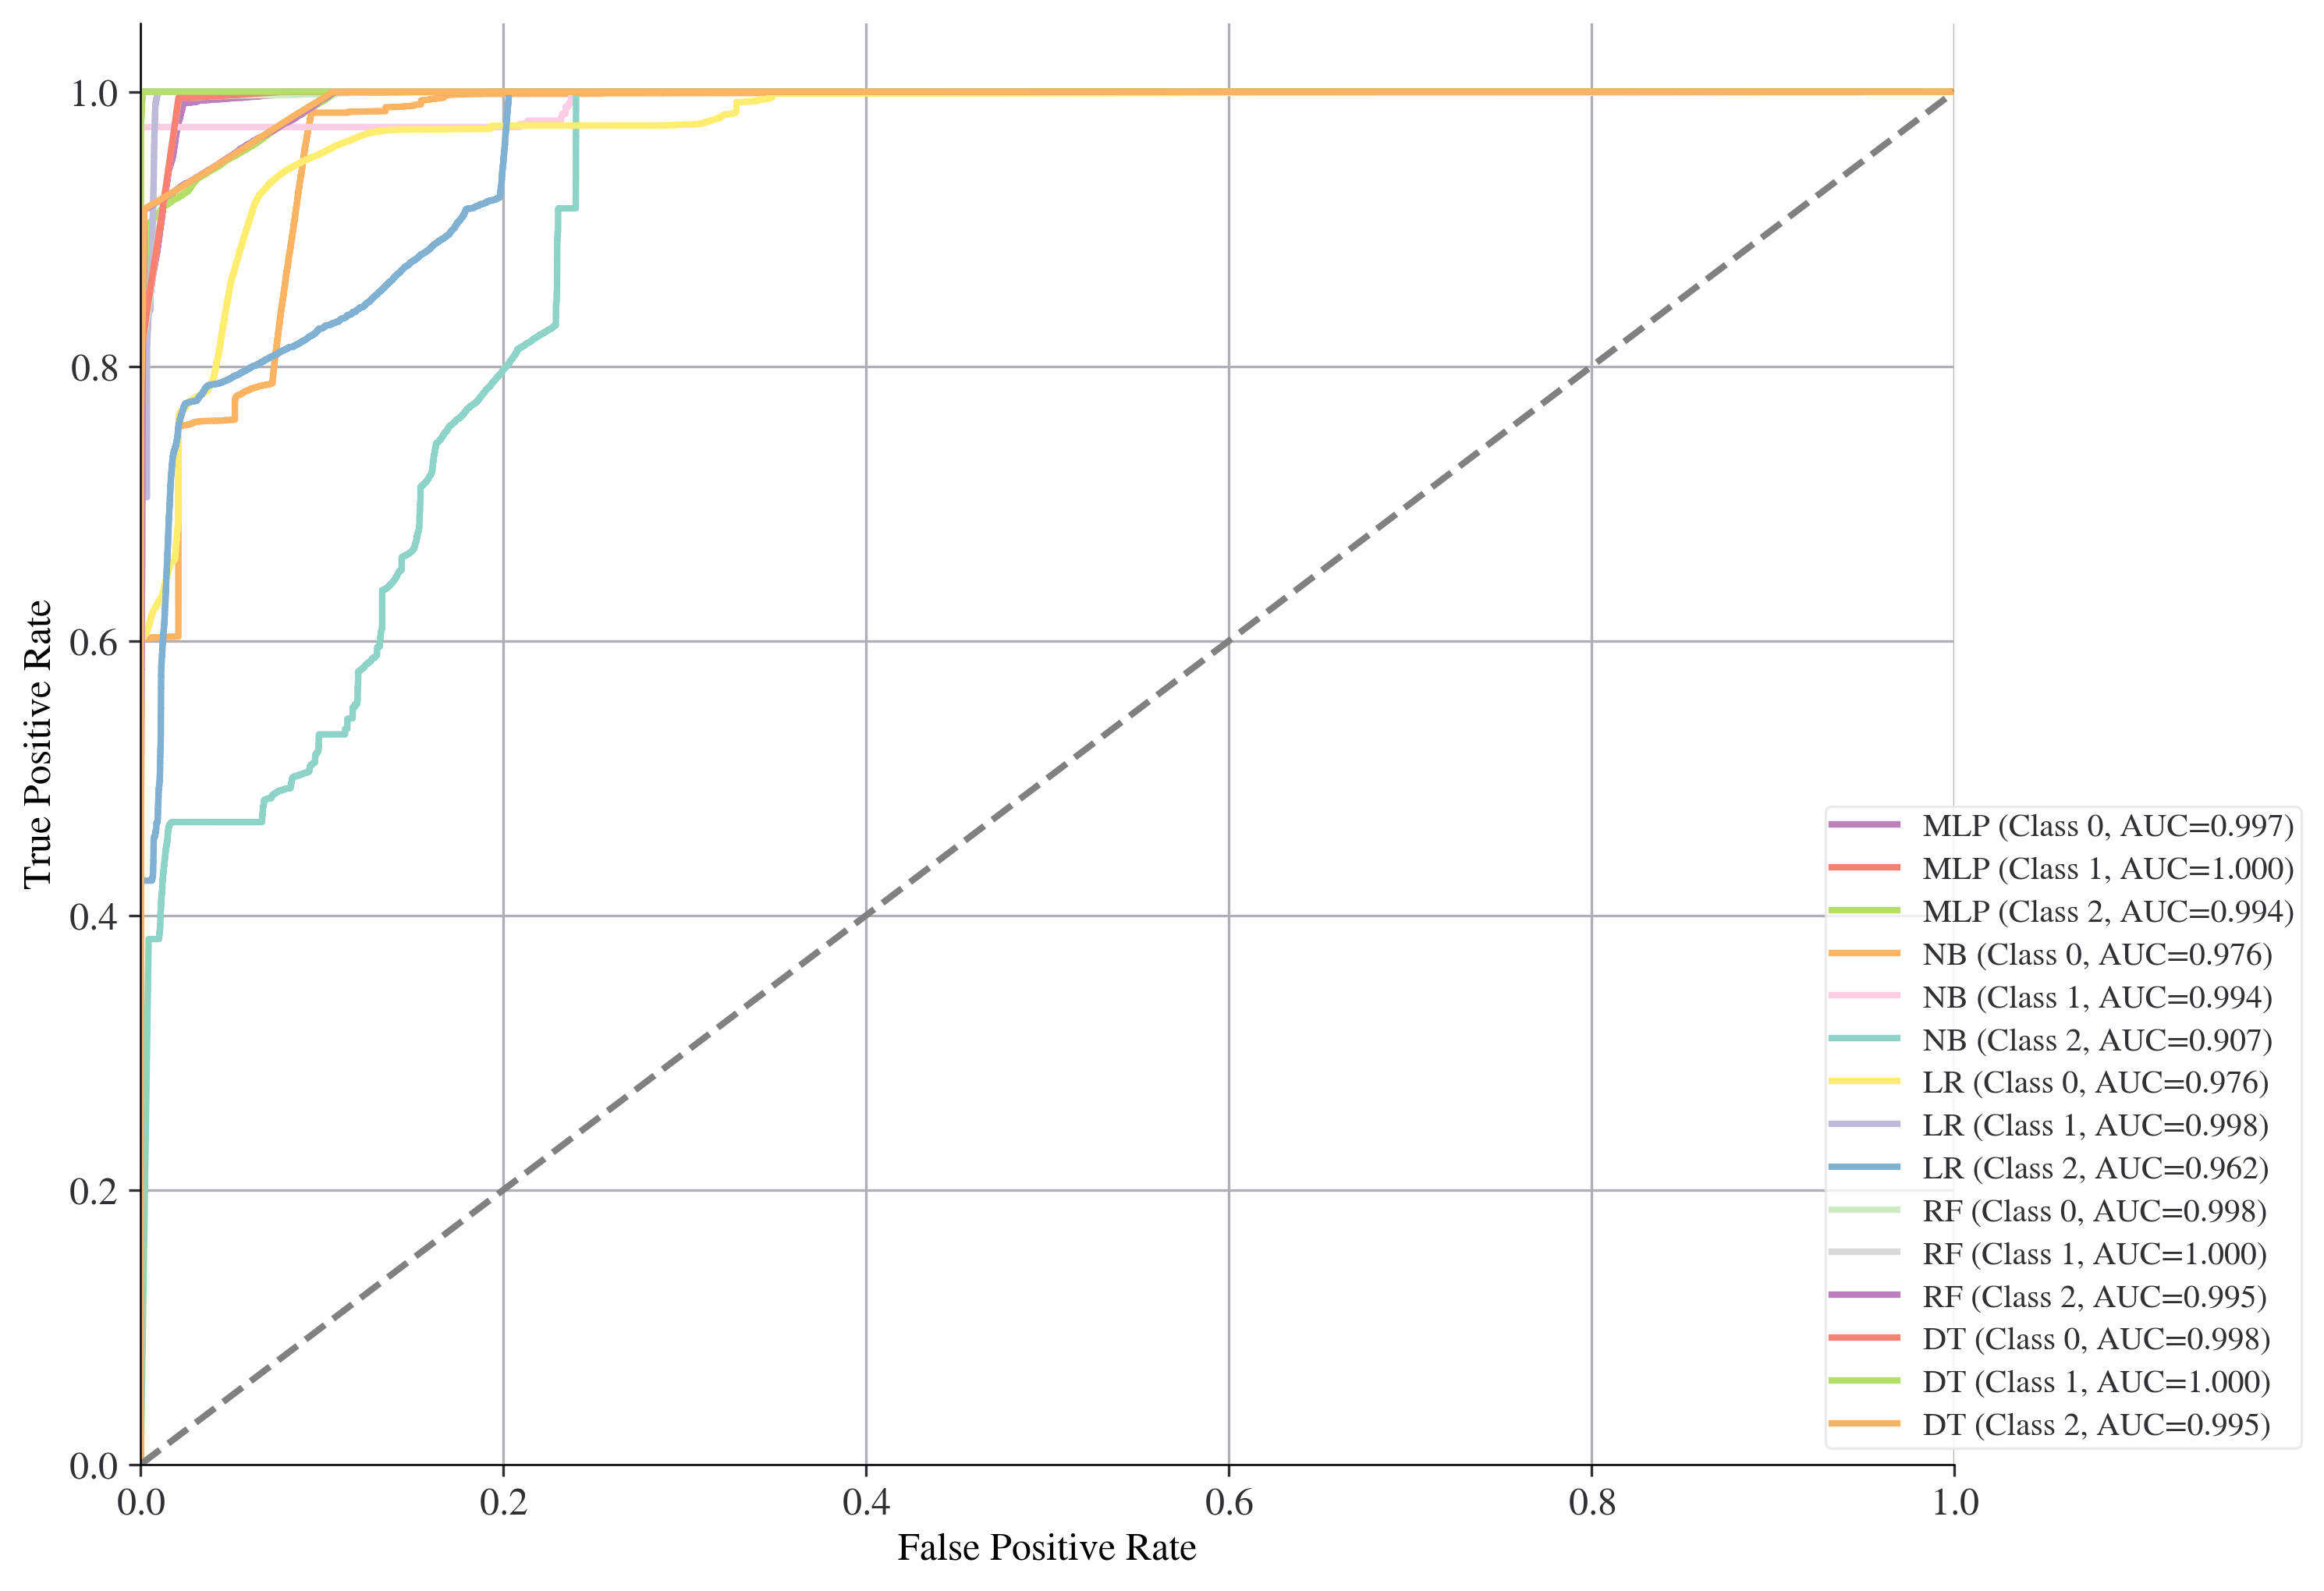

In [31]:
import os
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

plt.figure(figsize=(10, 8))

# Define the classes
n_classes = 3
classes = [0, 1, 2]

for model_key, result in results.items():
    # Binarize the labels for one-vs-rest ROC
    y_true_bin = label_binarize(result['expected'], classes=classes)
    y_pred = np.array(result['predicted'])
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot ROC curve for each class
        plt.plot(fpr[i], tpr[i], 
                label=f'{model_key} (Class {i}, AUC={roc_auc[i]:.3f})')
        
        # Save ROC data if needed
        filename = f'data/LAN_{model_key}_class{i}_ROC_data.csv'
        pd.DataFrame({
            'fpr': fpr[i], 
            'tpr': tpr[i], 
            'thresholds': thresholds
        }).to_csv(filename, index=False)

# Add diagonal line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", bbox_to_anchor=(1.2, 0))
plt.grid(True)

plt.savefig(os.path.join('images/', 'roc_lan_models.pdf'), 
            dpi=300, bbox_inches="tight")

---

## Results from Grid Search
> For conjunction of parameters, mean and std deviation

In [32]:
dados = []
for i in range(0,len(best.cv_results_['params'])):
    print(best.cv_results_['params'][i], best.cv_results_['mean_test_score'][i], 
          best.cv_results_['std_test_score'][i])
    dados.append([best.cv_results_['params'][i]['criterion'], 
                  best.cv_results_['params'][i]['max_depth'], best.cv_results_['mean_test_score'][i]])

{'class_weight': None, 'criterion': 'gini', 'max_depth': 1} 0.755636540943938 0.0008389256930774362
{'class_weight': None, 'criterion': 'gini', 'max_depth': 2} 0.8953203185897433 0.0006074047042900619
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3} 0.9563326681349085 0.00015649454899753954
{'class_weight': None, 'criterion': 'gini', 'max_depth': 4} 0.9883344424506525 9.103824368654632e-05
{'class_weight': None, 'criterion': 'gini', 'max_depth': 5} 0.9930719055725712 0.00013640845094175784
{'class_weight': None, 'criterion': 'gini', 'max_depth': 6} 0.9959667301936314 0.000159645932671115
{'class_weight': None, 'criterion': 'gini', 'max_depth': 7} 0.9974457725794065 0.0001045318262914639
{'class_weight': None, 'criterion': 'gini', 'max_depth': 8} 0.9974187284515325 0.00010978184002438222
{'class_weight': None, 'criterion': 'gini', 'max_depth': 9} 0.9973210042983044 0.00012154159558718959
{'class_weight': None, 'criterion': 'gini', 'max_depth': 10} 0.997230169089467 0.00013727

In [33]:
gini = {}
entropia = {}
for valores in dados:
    if valores[0] == "gini":
        gini.update({valores[1] : valores[2]})
    else:
        entropia.update({valores[1] : valores[2]})

In [34]:
plt.style.use('plot_style.txt')

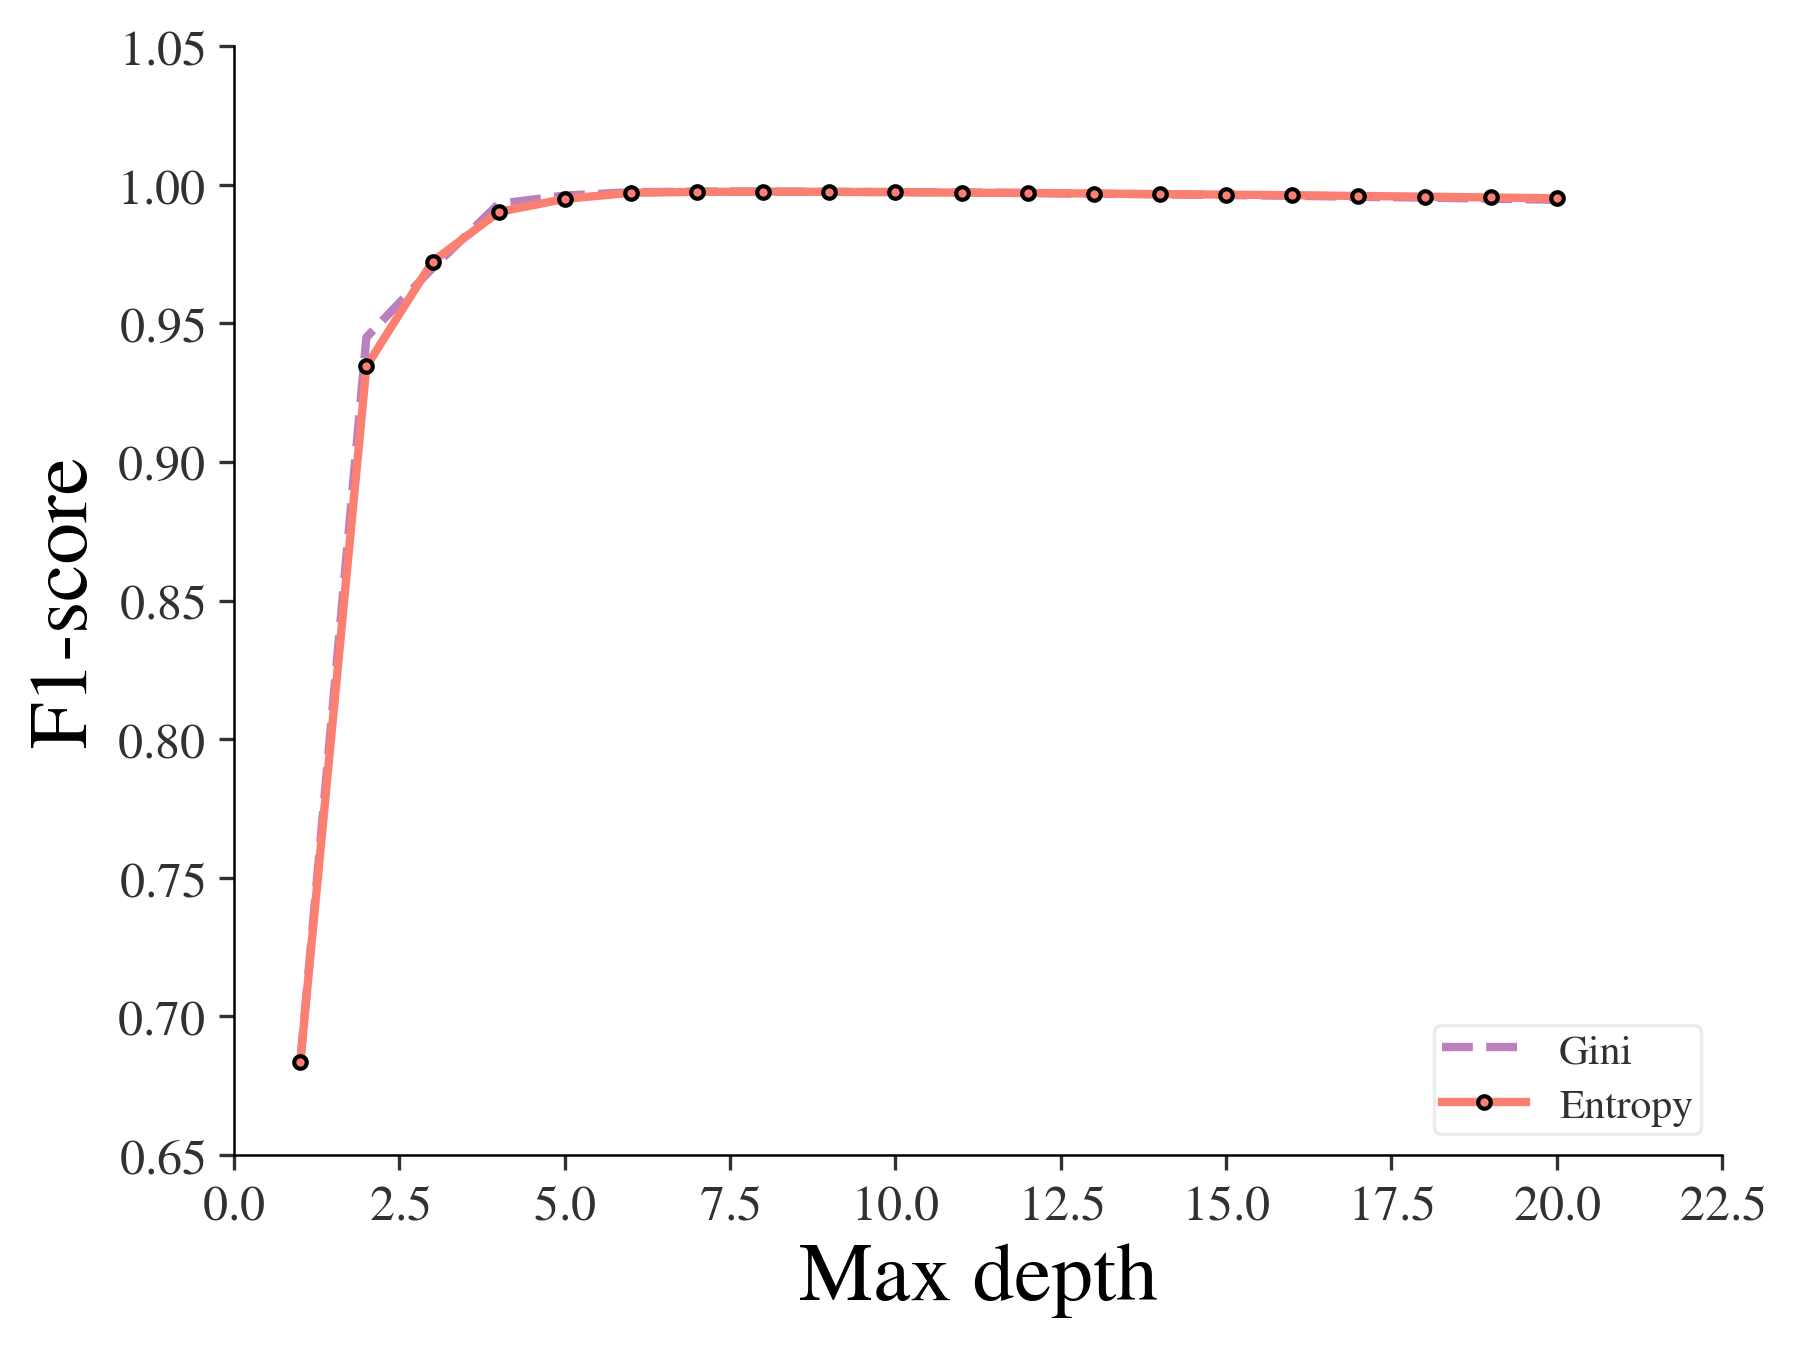

In [35]:
lists1 = sorted(gini.items())
lists2 = sorted(entropia.items())
x_gini, y_gini = zip(*lists1)
x_entropia, y_entropia = zip(*lists2)

#plt.figure(figsize=(10,8))
#plt.rcParams.update({'font.size': 15})

#plt.title('Performance according to grid-search parameters')
plt.ylabel('F1-score', fontsize=20)
plt.xlabel('Max depth', fontsize=20)
plt.plot(x_gini, y_gini, '--', label='Gini')
plt.plot(x_entropia, y_entropia, '.-', label='Entropy')
plt.legend(loc="lower right");
import os
plt.savefig(os.path.join('images/', 'grid_search_dt.pdf'), dpi=300, bbox_inches = "tight")

## ROC Analysis

In [36]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import label_binarize
import numpy as np

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)
clf = DecisionTreeClassifier(criterion='gini', max_depth=11, class_weight="balanced")

# Get predictions
predicted = cross_val_predict(clf, X, y, cv=kf, method='predict_proba')

# Get unique classes and binarize labels
classes = np.unique(y)
y_bin = label_binarize(y, classes=classes)

# Check data
print("Predicted shape:", predicted.shape)
print("First few predictions:\n", predicted[:5])
print("Unique classes:", classes)

# Calculate ROC curve for class 1 (or whichever class you want to focus on)
class_idx = 1  # Change this to look at different classes
fpr, tpr, thr = roc_curve(y_bin[:, class_idx], predicted[:, class_idx])

print("\nROC curve values:")
print("FPR first few values:", fpr[:5])
print("TPR first few values:", tpr[:5])

Predicted shape: (187910, 3)
First few predictions:
 [[0.68761714 0.         0.31238286]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]]
Unique classes: [0 1 2]

ROC curve values:
FPR first few values: [0.         0.         0.00013922 0.00025234 0.00032195]
TPR first few values: [0.         0.97422793 0.97681747 0.97950292 0.98184583]


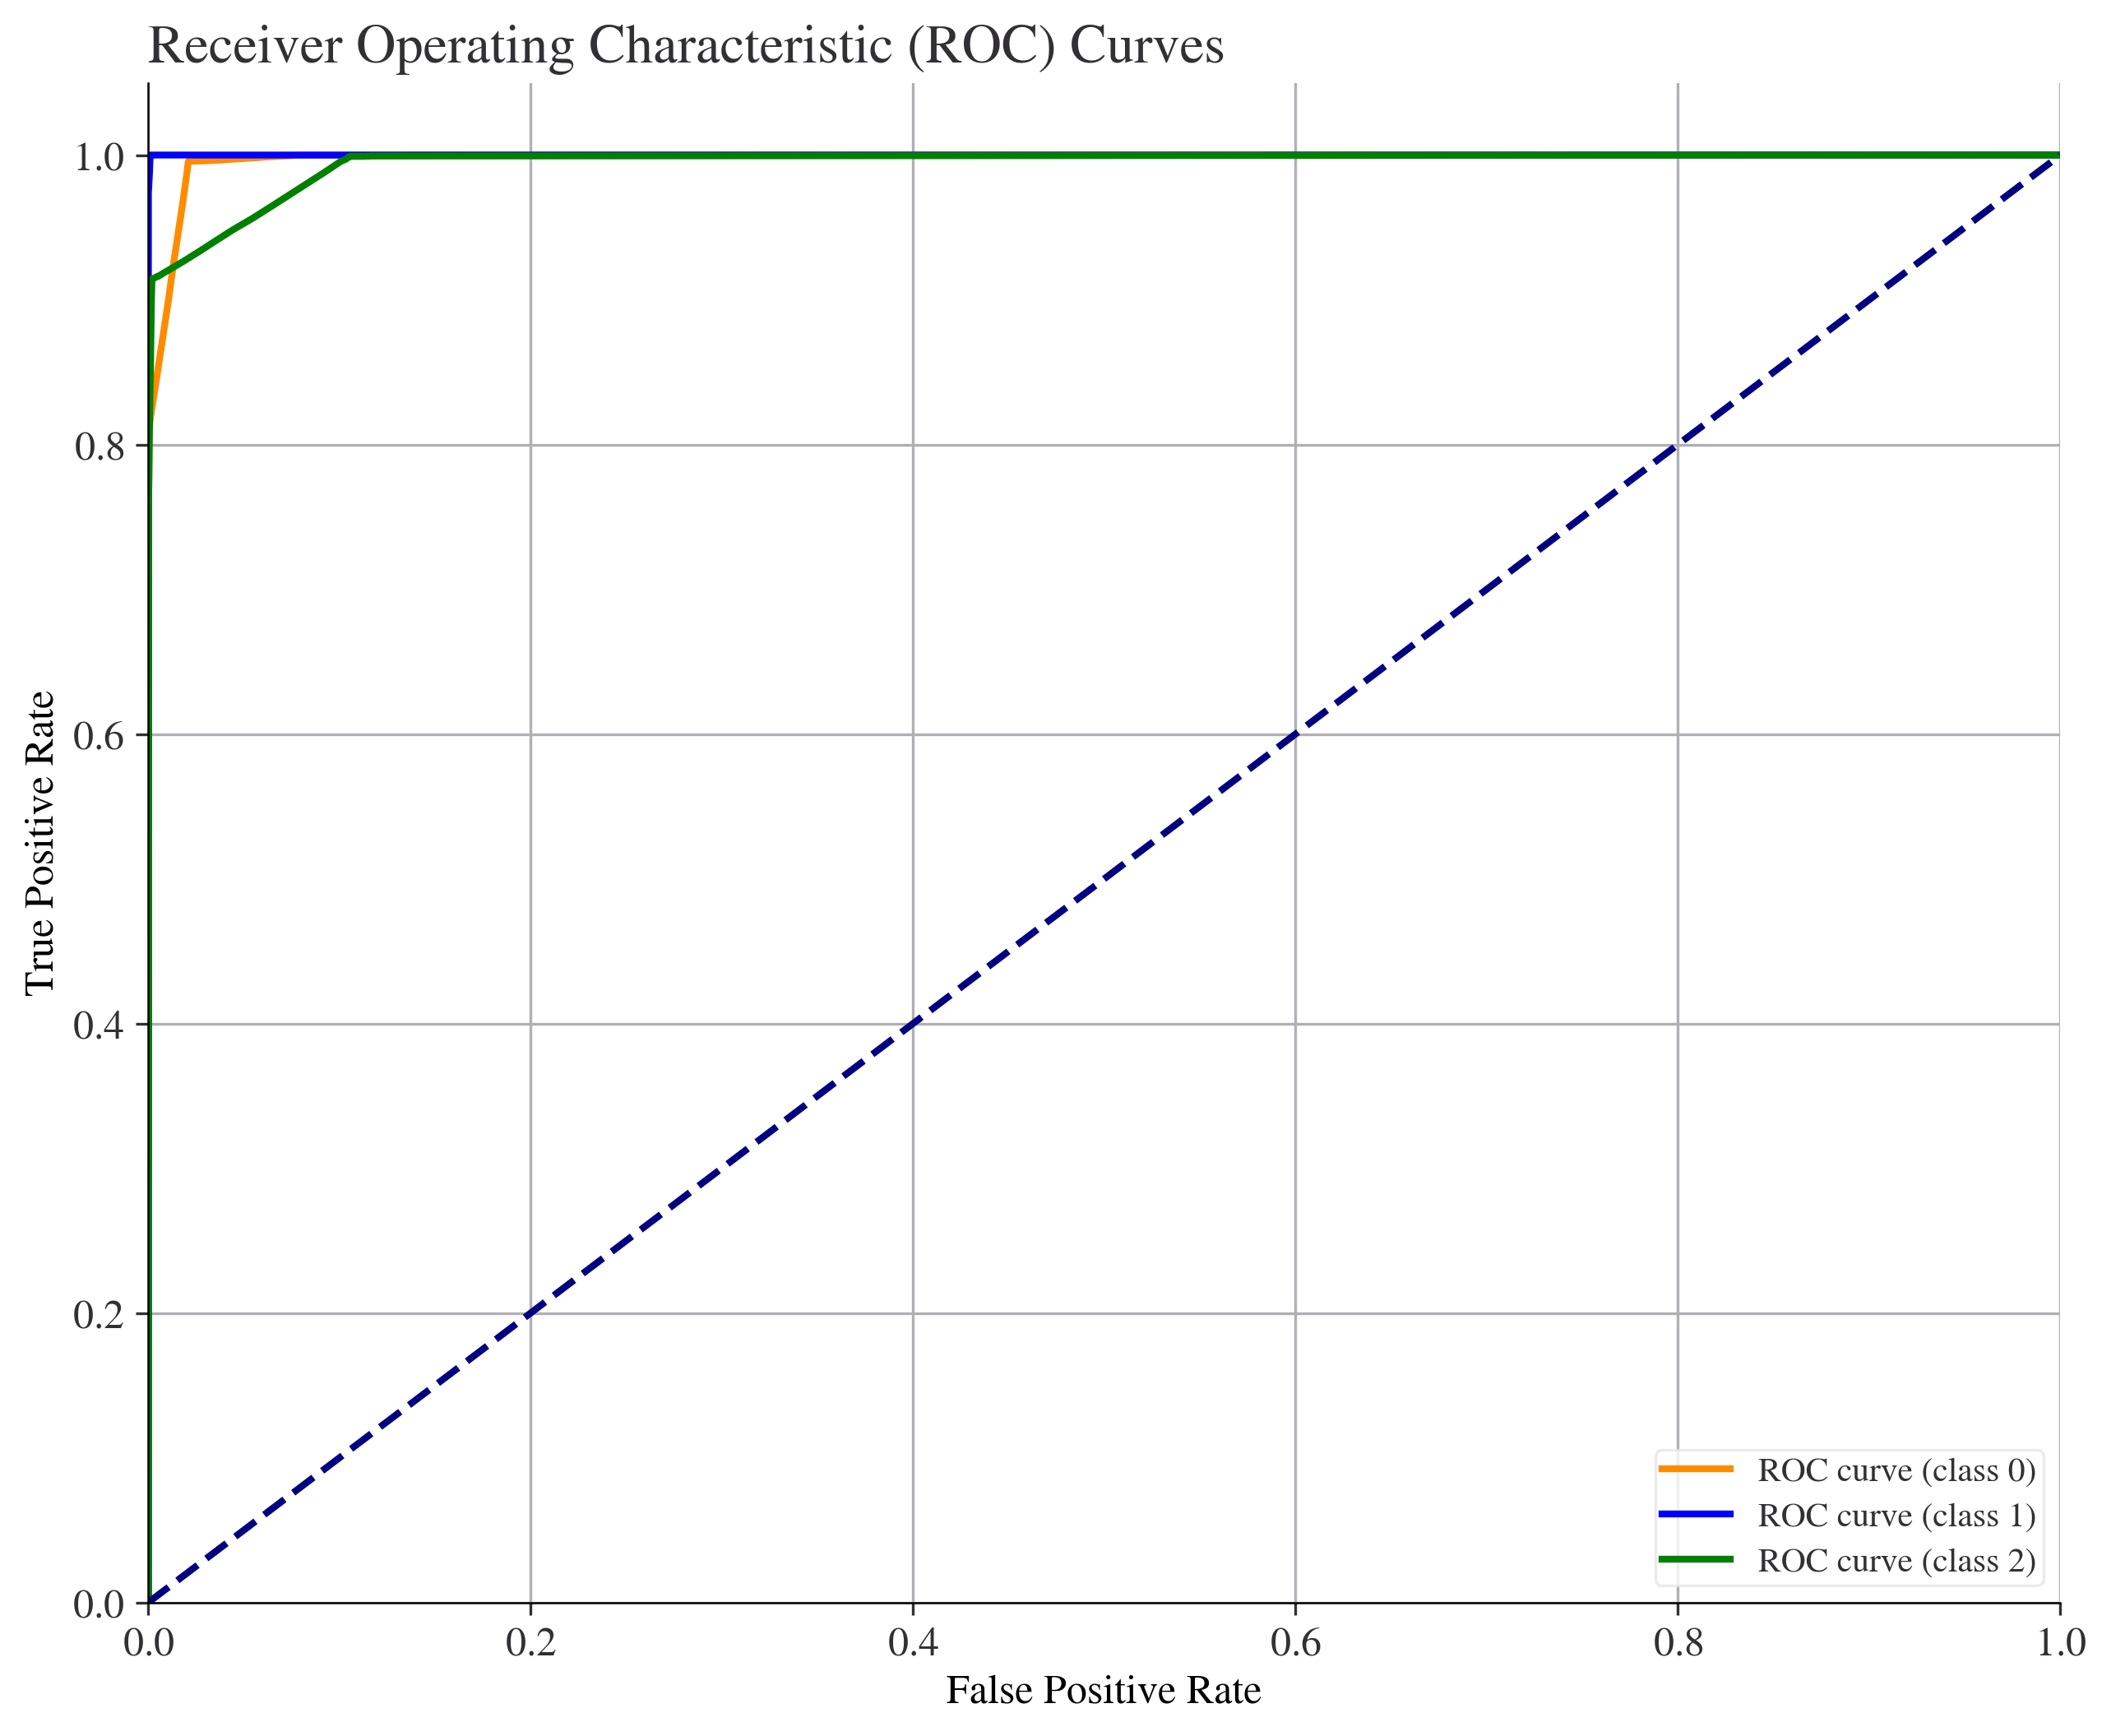

AUC for class 0: 0.998
AUC for class 1: 1.000
AUC for class 2: 0.995


In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# First, get predictions for all classes
predicted = cross_val_predict(clf, X, y, cv=kf, method='predict_proba')

# Prepare multiclass ROC
n_classes = len(np.unique(y))
y_test_bin = label_binarize(y, classes=np.unique(y))

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['darkorange', 'blue', 'green']
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], predicted[:, i])
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'ROC curve (class {i})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC scores for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], predicted[:, i])
    roc_auc = auc(fpr, tpr)
    print(f'AUC for class {i}: {roc_auc:.3f}')

In [38]:
def find_threshold(fpr, tpr, thresholds, goal, metric='fpr'):
    """
    Find appropriate threshold for a target FPR or TPR value
    Args:
        fpr: Array of false positive rates
        tpr: Array of true positive rates
        thresholds: Array of threshold values
        goal: Target value (e.g., 0.99)
        metric: 'fpr' or 'tpr'
    """
    if metric == 'fpr':
        # For FPR, we want values less than (1-goal)
        valid_idx = np.where(fpr <= (1-goal))[0]
    else:
        # For TPR, we want values greater than goal
        valid_idx = np.where(tpr >= goal)[0]
    
    if len(valid_idx) == 0:
        return None
    
    # Select appropriate index based on metric
    idx = valid_idx[-1] if metric == 'fpr' else valid_idx[0]
    
    if idx < len(thresholds):
        return thresholds[idx]
    return None

In [39]:
goal = 0.99
fpr_threshold = find_threshold(fpr, tpr, thr, goal, 'fpr')
tpr_threshold = find_threshold(fpr, tpr, thr, goal, 'tpr')

if fpr_threshold is not None:
    print(f'Threshold to achieve FPR < {1-goal:.2f}: {fpr_threshold:.4f}')
else:
    print(f'Could not find threshold for FPR < {1-goal:.2f}')

if tpr_threshold is not None:
    print(f'Threshold to achieve TPR > {goal:.2f}: {tpr_threshold:.4f}')
else:
    print(f'Could not find threshold for TPR > {goal:.2f}')

# You might also want to print the actual achievable ranges:
print(f'\nActual ranges in data:')
print(f'FPR range: {fpr.min():.4f} to {fpr.max():.4f}')
print(f'TPR range: {tpr.min():.4f} to {tpr.max():.4f}')

Could not find threshold for FPR < 0.01
Could not find threshold for TPR > 0.99

Actual ranges in data:
FPR range: 0.0000 to 1.0000
TPR range: 0.0000 to 1.0000


In [40]:
goal = 0.95
fpr_threshold = find_threshold(fpr, tpr, thr, goal, 'fpr')
tpr_threshold = find_threshold(fpr, tpr, thr, goal, 'tpr')

if fpr_threshold is not None:
    print(f'Threshold to achieve FPR < {1-goal:.2f}: {fpr_threshold:.4f}')
else:
    print(f'Could not find threshold for FPR < {1-goal:.2f}')

if tpr_threshold is not None:
    print(f'Threshold to achieve TPR > {goal:.2f}: {tpr_threshold:.4f}')
else:
    print(f'Could not find threshold for TPR > {goal:.2f}')

# You might also want to print the actual achievable ranges:
print(f'\nActual ranges in data:')
print(f'FPR range: {fpr.min():.4f} to {fpr.max():.4f}')
print(f'TPR range: {tpr.min():.4f} to {tpr.max():.4f}')

Could not find threshold for FPR < 0.05
Could not find threshold for TPR > 0.95

Actual ranges in data:
FPR range: 0.0000 to 1.0000
TPR range: 0.0000 to 1.0000


In [41]:
goal = 0.90
fpr_threshold = find_threshold(fpr, tpr, thr, goal, 'fpr')
tpr_threshold = find_threshold(fpr, tpr, thr, goal, 'tpr')

if fpr_threshold is not None:
    print(f'Threshold to achieve FPR < {1-goal:.2f}: {fpr_threshold:.4f}')
else:
    print(f'Could not find threshold for FPR < {1-goal:.2f}')

if tpr_threshold is not None:
    print(f'Threshold to achieve TPR > {goal:.2f}: {tpr_threshold:.4f}')
else:
    print(f'Could not find threshold for TPR > {goal:.2f}')

# You might also want to print the actual achievable ranges:
print(f'\nActual ranges in data:')
print(f'FPR range: {fpr.min():.4f} to {fpr.max():.4f}')
print(f'TPR range: {tpr.min():.4f} to {tpr.max():.4f}')

Could not find threshold for FPR < 0.10
Could not find threshold for TPR > 0.90

Actual ranges in data:
FPR range: 0.0000 to 1.0000
TPR range: 0.0000 to 1.0000


In [42]:
# Define thresholds based on the actual probability distribution
thresholds_to_check = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

for thresh in thresholds_to_check:
    print('Using threshold = %.2f, we have FPR=%.4f and TPR=%.4f' % 
          (thresh, fpr[np.where(thr <= thresh)[0][0]], tpr[np.where(thr <= thresh)[0][0]]))

Using threshold = 0.10, we have FPR=0.0001 and TPR=0.7658
Using threshold = 0.20, we have FPR=0.0001 and TPR=0.7658
Using threshold = 0.30, we have FPR=0.0001 and TPR=0.7658
Using threshold = 0.40, we have FPR=0.0001 and TPR=0.7658
Using threshold = 0.50, we have FPR=0.0001 and TPR=0.7658
Using threshold = 0.60, we have FPR=0.0001 and TPR=0.7658
Using threshold = 0.70, we have FPR=0.0001 and TPR=0.7658
Using threshold = 0.80, we have FPR=0.0001 and TPR=0.7658
Using threshold = 0.90, we have FPR=0.0001 and TPR=0.7658


## Feature Importance Evaluation

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Create a custom scorer for multiclass F1
f1_scorer = make_scorer(f1_score, average='macro')  # or 'weighted', 'micro'

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)
clf = DecisionTreeClassifier(criterion='gini', max_depth=11, class_weight="balanced")

scores = cross_val_score(clf, X, y, cv=kf, scoring=f1_scorer)

print("F1-Score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1-Score: 0.978 (+/- 0.00)


In [44]:
clf.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=11)

In [45]:
import pandas as pd

# Get feature importances
importances = clf.feature_importances_

# Create DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({
    'feature_name': X.columns,
    'feature_importance': importances
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values('feature_importance', ascending=False)

# Print feature importances
for index, row in feature_importance_df.iterrows():
    print(row.feature_importance, row.feature_name)

0.7140388711357682 ip.len
0.08042383226809927 tcp.window_size
0.06215792973257521 tcp.flags.syn
0.048325837217219524 tcp.hdr_len
0.042828511164078924 ip.flags.df
0.032669136936379656 tcp.len
0.01615031512740709 tcp.flags.ack
0.0020723736590030615 ip.id
0.0011029748305073875 ip.dsfield
0.0002302179284271246 tcp.flags.reset
5.345408806753327e-13 tcp.flags.fin
0.0 tcp.flags.push
0.0 tcp.flags.urg
0.0 tcp.flags.cwr
0.0 tcp.urgent_pointer


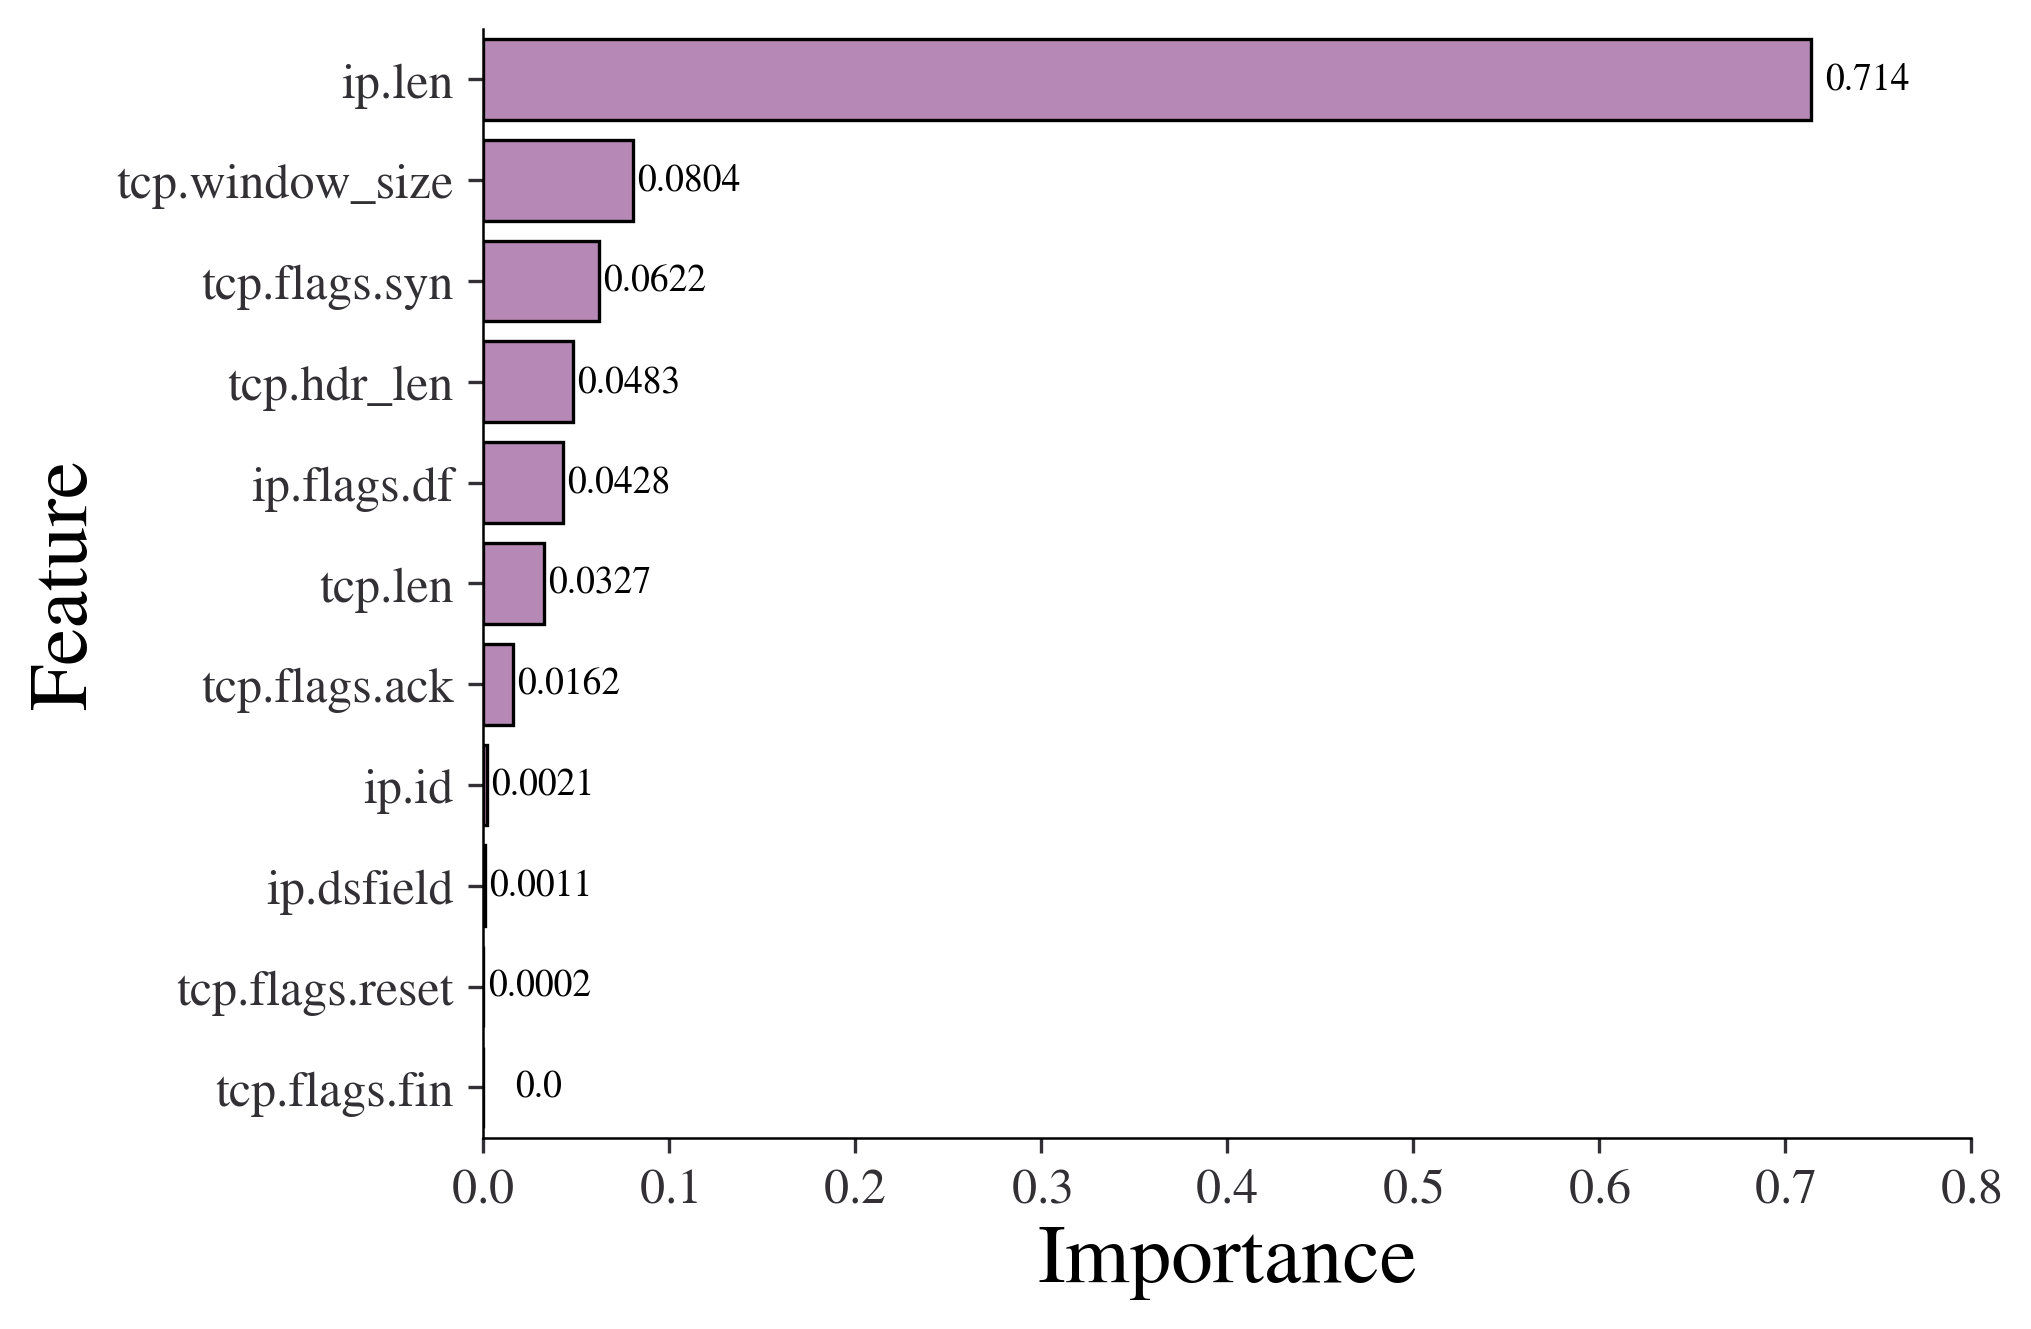

In [46]:
feature_importance = np.array(clf.feature_importances_)
feature_names = np.array(X.columns)

data = {'feature_name': feature_names,
       'feature_importance': feature_importance}

fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

relevantes = fi_df[fi_df.feature_importance > 0]

#plt.figure(figsize=(10,8))
g=sns.barplot(x=relevantes['feature_importance'], y=relevantes['feature_name'])

plt.xlabel('Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20);
i=0
for index, row in relevantes.iterrows():
    g.text(row.feature_importance+0.03, i, round(row.feature_importance, 4), color='black', ha="center", va="center", fontsize=9)
    i+=1
plt.savefig(os.path.join('images/', 'feature_importance_dt.pdf'), dpi=300, bbox_inches = "tight")

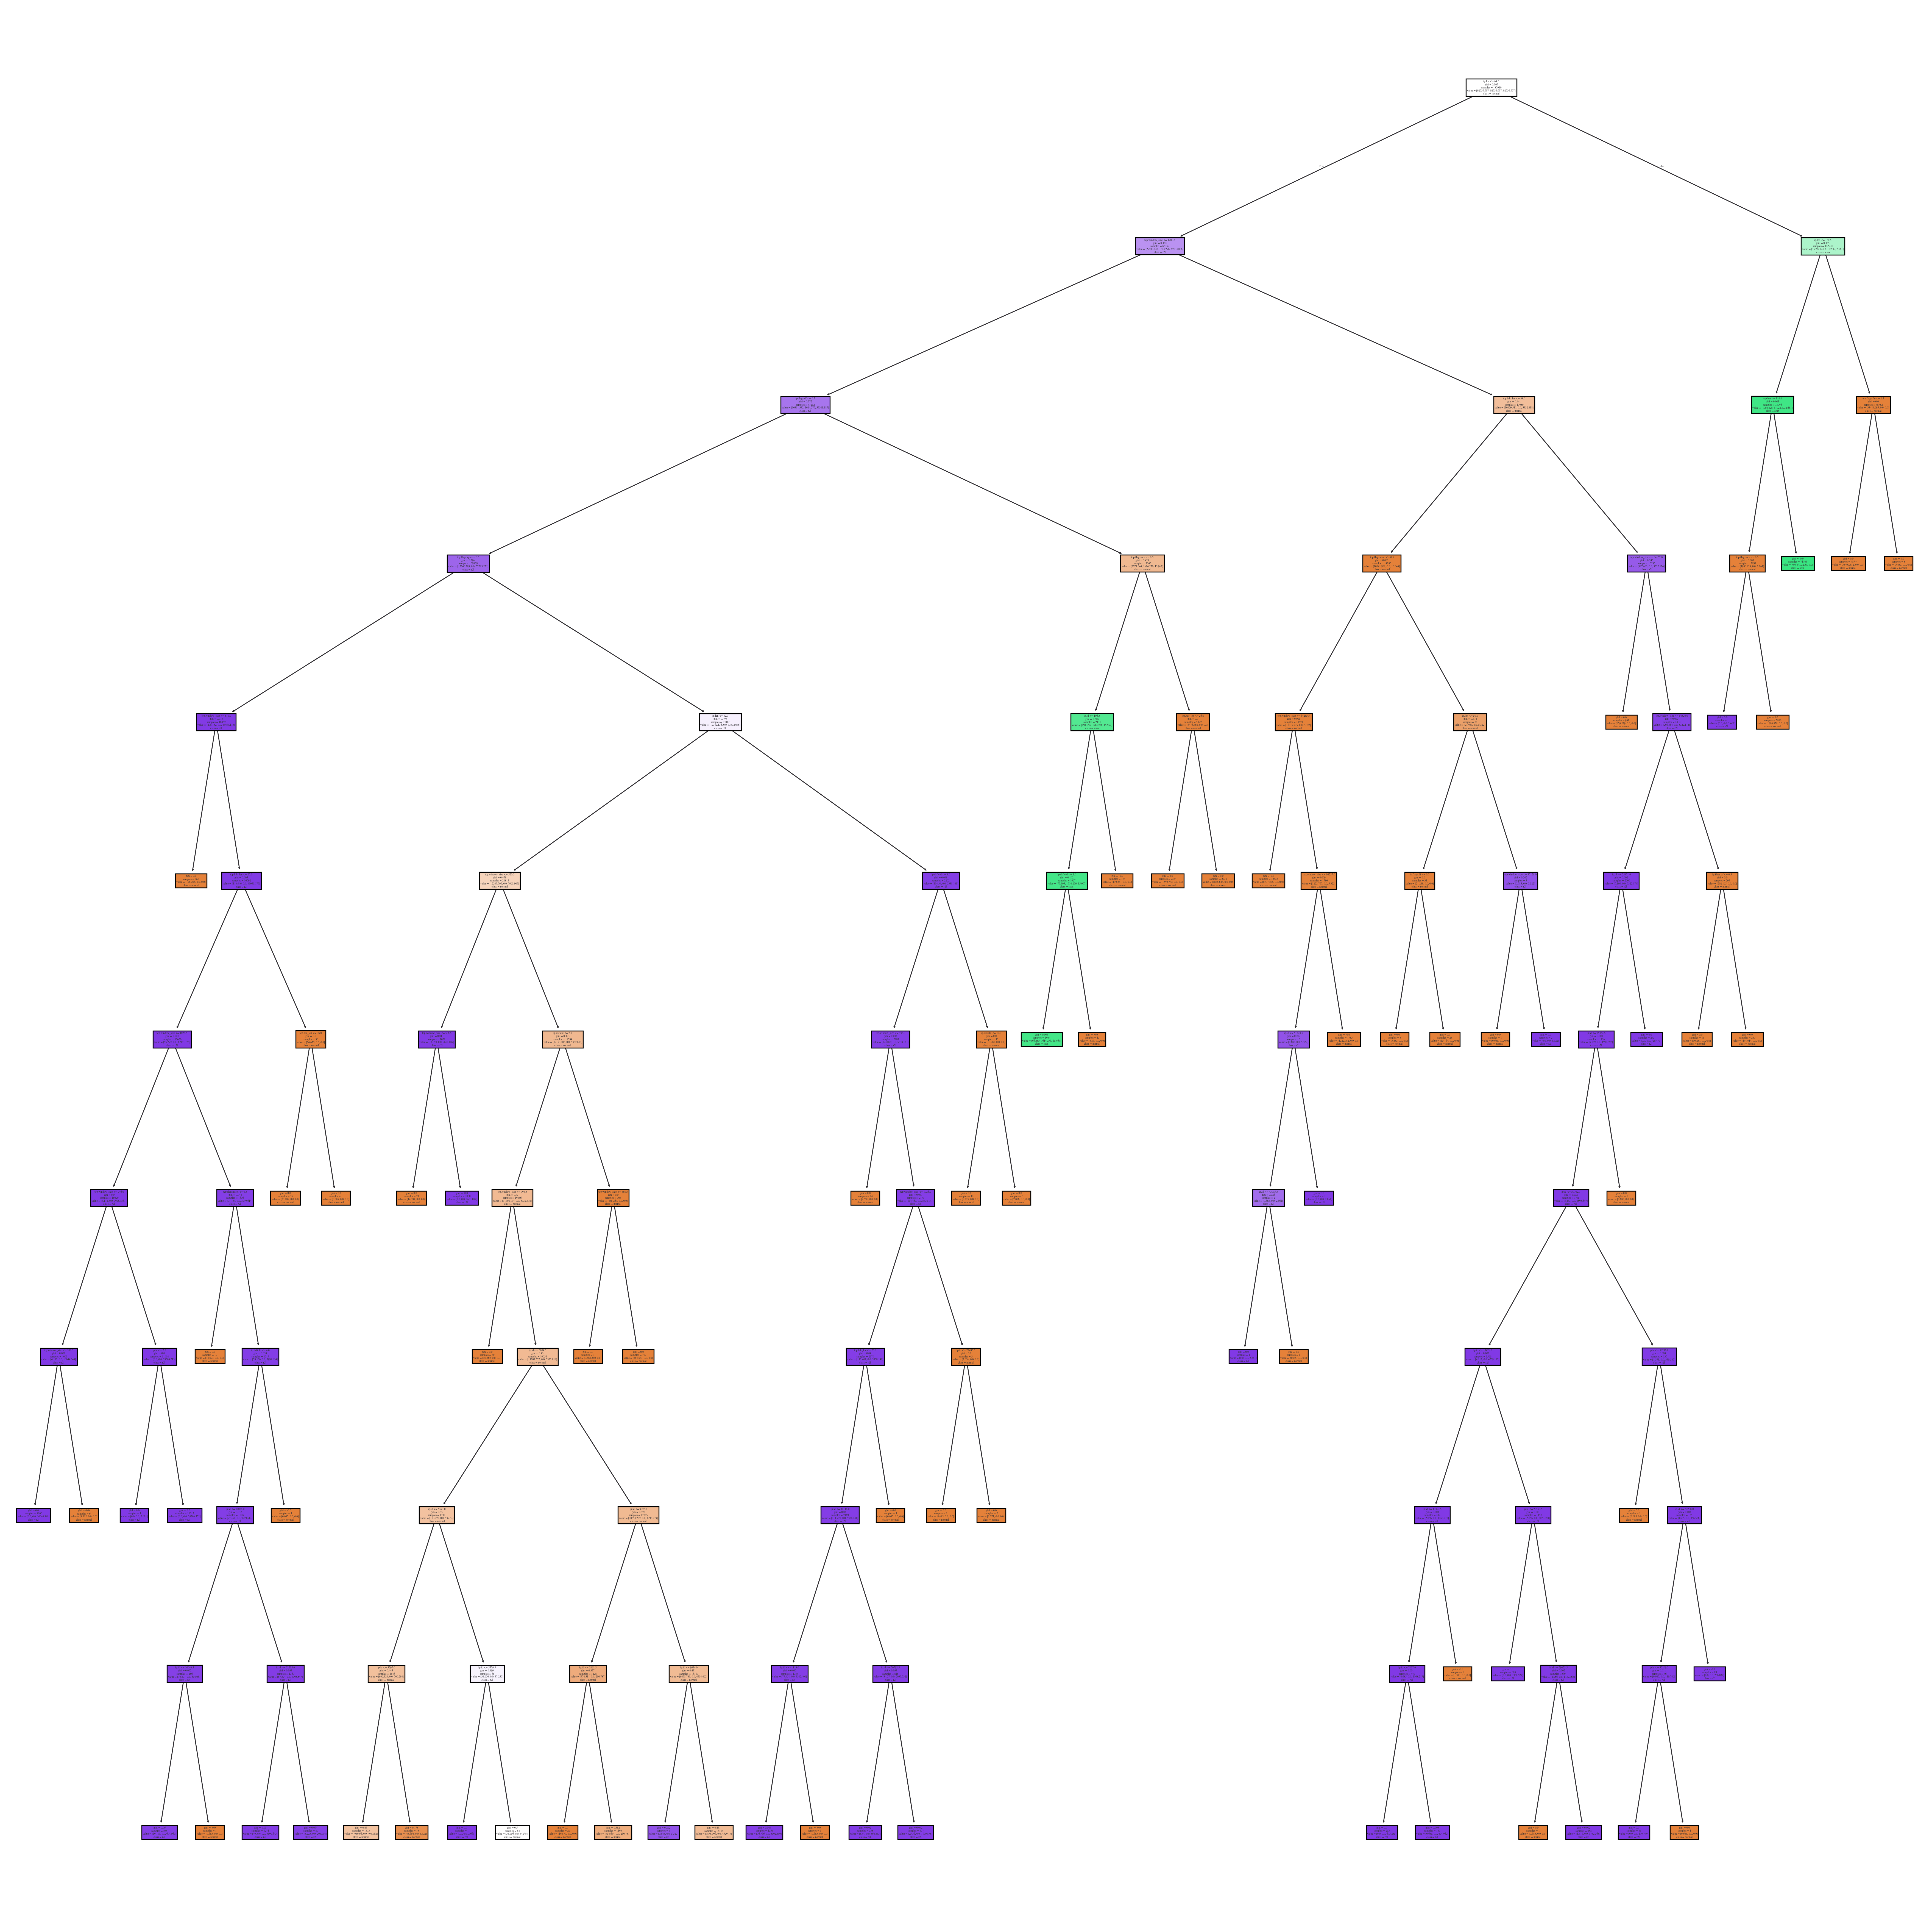

In [47]:
from sklearn import tree

fn = X.columns
cn = ['normal', 'scan', 'r2l']  # Updated to include all three classes

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,30), dpi=300)
tree.plot_tree(clf,
               feature_names=fn, 
               class_names=cn,
               filled=True)
plt.show()

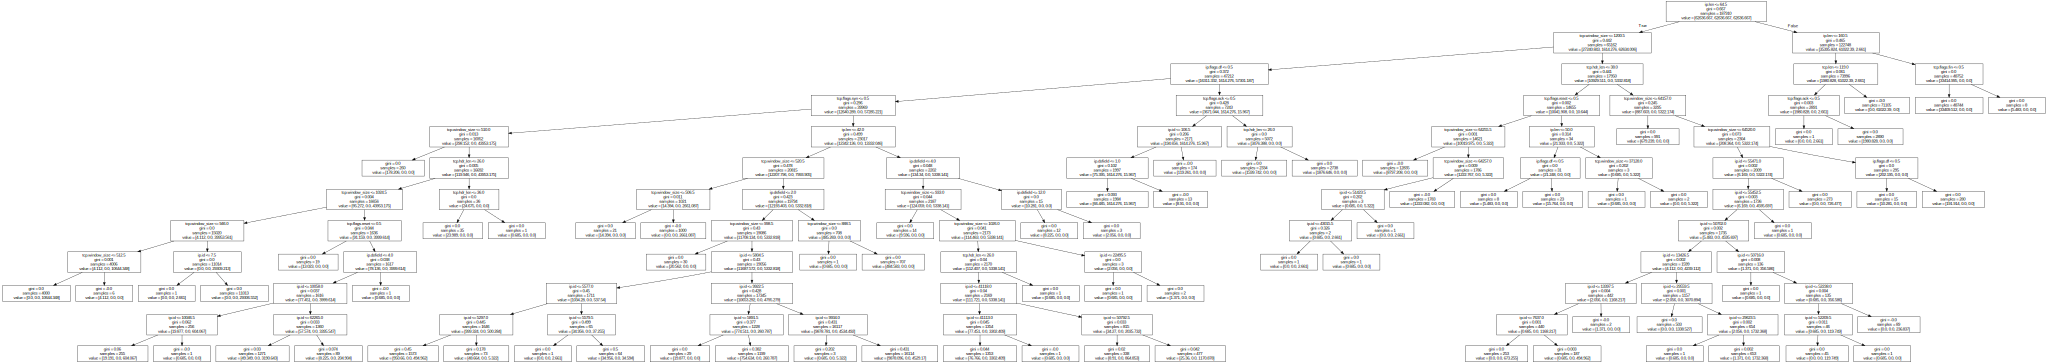

In [48]:
from sklearn.tree import export_graphviz
import graphviz

graphviz.Source(export_graphviz(clf, out_file = None, feature_names=X.columns.tolist()))

# Inference model

In [49]:
import emlearn
cmodel = emlearn.convert(clf)
#cmodel.save(file='../4. [R]ealiz[A]tion/1. Local Area Network/reference/scan.h');

In [50]:
X.columns

Index(['ip.id', 'ip.flags.df', 'ip.len', 'ip.dsfield', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.urgent_pointer'],
      dtype='object')